In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data_files/AAPL_combined.csv.gz")
df.columns
AAPL_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})

In [25]:
AAPL_returns

,time_stamp,log_return
0,2021-08-02 09:30:00,0.000478
1,2021-08-02 09:31:00,0.000853
2,2021-08-02 09:32:00,-0.002219
3,2021-08-02 09:33:00,0.000380
4,2021-08-02 09:34:00,0.000546
...,...,...
562926,2025-02-28 15:55:00,0.000622
562927,2025-02-28 15:56:00,-0.000062
562928,2025-02-28 15:57:00,0.000994
562929,2025-02-28 15:58:00,0.001614


In [27]:
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')

In [28]:
daily_variance = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

In [33]:
daily_variance.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2025-09-17', '2025-09-18', '2025-09-19', '2025-09-22',
               '2025-09-23', '2025-09-24', '2025-09-25', '2025-09-26',
               '2025-09-29', '2025-09-30'],
              dtype='datetime64[ns]', name='time_stamp', length=1444, freq=None)

Text(0.5, 1.0, 'Apple Variance')

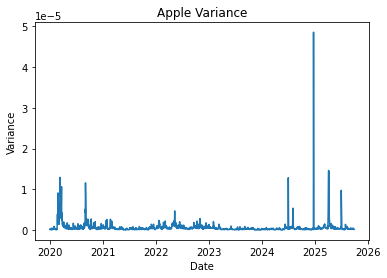

In [37]:
plt.plot(daily_variance.index, daily_variance.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")

In [67]:
daily_variance.values.max()

4.8499410420880676e-05

In [ ]:
APPL_daily_variance = pd.DataFrame({
    "timestamp": daily_variance.index,
    "variance": daily_variance.values

})
np.corrcoef(APPL_daily_variance.variance[0], APPL_daily_variance.variance[1])
APPL_daily_variance.variance[0]
# for i in range(len(APPL_daily_variance)-1):
#     print(APPL_daily_variance.variance[i])
timestamp = []
correlation = []
for i in range(len(APPL_daily_variance)-1):
    timestamp.append([APPL_daily_variance.timestamp[i], APPL_daily_variance.timestamp[i+1]])
    correlation.append(np.corrcoef(APPL_daily_variance.variance[i], APPL_daily_variance.variance[i+1])[0,1])
APPL_correlation = pd.DataFrame({
    "timestamps": timestamp,
    "correlation": correlation
})
APPL_correlation

,timestamps,correlation
0,"[2020-01-02 00:00:00, 2020-01-03 00:00:00]",NaN
1,"[2020-01-03 00:00:00, 2020-01-06 00:00:00]",NaN
2,"[2020-01-06 00:00:00, 2020-01-07 00:00:00]",NaN
3,"[2020-01-07 00:00:00, 2020-01-08 00:00:00]",NaN
4,"[2020-01-08 00:00:00, 2020-01-09 00:00:00]",NaN
...,...,...
1438,"[2025-09-23 00:00:00, 2025-09-24 00:00:00]",NaN
1439,"[2025-09-24 00:00:00, 2025-09-25 00:00:00]",NaN
1440,"[2025-09-25 00:00:00, 2025-09-26 00:00:00]",NaN
1441,"[2025-09-26 00:00:00, 2025-09-29 00:00:00]",NaN


In [64]:
APPL_daily_variance

,timestamp,variance
0,2020-01-02,1.997834e-07
1,2020-01-03,3.183479e-07
2,2020-01-06,1.903965e-07
3,2020-01-07,2.055122e-07
4,2020-01-08,2.325188e-07
...,...,...
1439,2025-09-24,2.589987e-07
1440,2025-09-25,3.928186e-07
1441,2025-09-26,2.358282e-07
1442,2025-09-29,1.792936e-07


In [44]:
correlation_APPL

0.23976389122492983

In [38]:
df = pd.read_csv("data/BEP_combined.csv.gz")
df.columns
BEP_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})

Text(0.5, 1.0, 'BEP Variance')

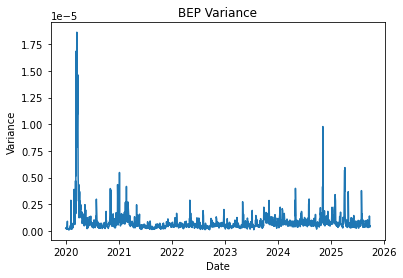

In [39]:
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
plt.plot(daily_variance_BEP.index, daily_variance_BEP.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance")

Text(0.5, 1.0, 'LLY Variance')

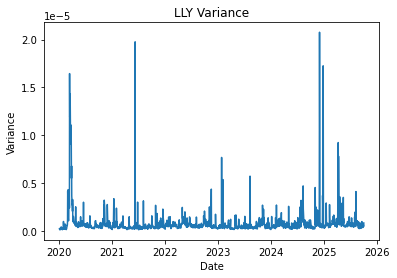

In [40]:
df = pd.read_csv("data/LLY_combined.csv.gz")
df.columns
LLY_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")
